## Batch Normalization and Layer Normalization

Training deep neural networks presents several challenges that can hinder convergence and generalization:

>1. **Internal covariate shift**: As the input data passes through multiple layers, the distribution of activations can change, making it difficult for the model to adapt and learn effectively.
>2. **Vanishing and exploding gradients**: Deep networks can suffer from vanishing or exploding gradients, where the gradients become too small or too large during backpropagation, preventing effective weight updates.
>3. **Sensitivity to initialization**: The initial weights of the network can significantly impact the training process, and poor initialization can lead to slow convergence or even training failure.

Batch normalization address these challenges by normalizing the activations within each mini-batch, helping to stabilize the training process and improve the model's performance. 

from [Deep Learning Training Challenges](https://www.datacamp.com/tutorial/batch-normalization-tensorflow)

#### Internal covariate shift

Internal covariate shift is the change in the distribution of network activations due to the change in network parameters during training. <br>

[Internal Covariate Shift: How Batch Normalization can speed up Neural Network Training](https://medium.com/analytics-vidhya/internal-covariate-shift-an-overview-of-how-to-speed-up-neural-network-training-3e2a3dcdd5cc)

### Batch Normalization

>Training Deep Neural Networks is complicated by the fact that the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities. We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs. Our method draws its strength from making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization, and in some cases eliminates the need for Dropout. Applied to a stateof-the-art image classification model, Batch Normalization achieves the same accuracy with 14 times fewer training steps, and beats the original model by a significant margin. Using an ensemble of batch-normalized networks, we improve upon the best published result on ImageNet classification: reaching 4.82% top-5 test error, exceeding the accuracy of human raters. <br>
<br>
The abstract from the Batch Normalization paper by Ioffe & Szegedy (2015)

Batch normalization is a technique that normalizes the activations of a layer within a mini-batch during the training of deep neural networks. Batch normalization is a neural network layer that is now commonly used in many architecture. It often gets added as part of a Linear or Convolutional block and helpts to stabilize the network during training.

Before performing batch normalization, Let's look at Internal covariate shift. 
To visualize the internal covariate shift, you need to under `hook`.

#### Hook

**What are hooks?**
> Hooks are functions that automatically execute after a prticular event. They are not unique to PyToch

For example:
* Website displays an ad after you visit *N* Different pages
* Banking app sends a notification when funds are added to your account


**In PyTorch**:

A hook can be registered on a `Tensor` or a `nn.Module.` A hook is basically a function that is executed when the either `forward` or `backward` is called.

Types of Hooks:

1. **Forward Pre-Hooks**

   Forward pre-hooks allow you to inspect or modify the input data before it is processed by the module.<br>

   Forward pre-hooks are used to:
   
    * Preprocessing input data
    * Adding noise for data augmentation
    * Dynamically modifying the input based on certain conditions.
             
2. **Forward Hooks**

    Forward hooks allows to inspect or modify the data flowing through the layer during forward process.<br>

    Forward hooks can be used for:

    * Visualize activations or feature maps
    * Compute statistics on the activations
    * Perform any custom operation on the layer's output
3. **Backward Hooks**
 
    Backward hook allows to inspect, modify, or even replace the gradients before they are used for weight updates during optimization

   Backward hooks can be used for:

   * Clip gradients to prevent exploding gradients
   * Add noise to gradients for regularization
   * Implement custom gradient=based optimization techniques

#### Hooks on Tensors:
* **Registering a Tensor for a Hook**: To register a tensor for a hook, you use the `register_hook` method on the tensor object, providing the hook function as an argument.
* **Removing a Hook**: To remove a hook from a tensor, `remove( )` method is called on the hook handle that is returned when registering the hook.

  Example:
  ```python
    import torch

    # Define a tensor
    tensor = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
    
    # Define a hook function to modify gradients
    def gradient_hook(grad):
        return grad * 2  # Modify gradients
    
    # Register the tensor for a backward hook
    hook_handle = tensor.register_hook(gradient_hook)
    
    # Perform some operations involving the tensor
    output = tensor.sum()
    
    # Backward pass
    output.backward()
    
    # Remove the hook
    hook_handle.remove()
  ```
   
Further reading:
* [PyTorch 101: Understanding Hooks](https://www.digitalocean.com/community/tutorials/pytorch-hooks-gradient-clipping-debugging)
* [What are PyTorch Hooks and how are they applied in neural network layers?](https://www.geeksforgeeks.org/what-are-pytorch-hooks-and-how-are-they-applied-in-neural-network-layers/)

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

%load_ext autoreload 
%autoreload 2
import utils

In [2]:
a = torch.ones(5, requires_grad=True)
b = 2 * a
b.retain_grad()

# def print_grad(grad):
#     print(grad)
# b.register_hook(print_grad)

# labmda function for clearity
b.register_hook(lambda grad:print(grad))
c = b.mean()
c.retain_grad()
c.backward()


tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])


#### Hook on Module

You can register hooks on any `torch.nn.Module` subclass (e.g., layers, models) using the `register_forward_hook` and `register_full_backward_hook` methods. These hooks take a function as input, which will be called when the forward or backward pass reaches the corresponding layer.

```python
    hook(module, input, output) -> None or modified output
```

***Caution***: `register_backword_hook()` is deprecated in favor of `register_full_backward)hook()`

##### `register_forward_hook()`

In [3]:
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    
    nn.Flatten(),
    # # 128 -> 32
    nn.Linear(128, 10)
    # nn.Linear(32, 10)
    # 10
)

In [4]:
outputs = {}
def save_output(name, module,inp, out):
    module_name = f'{name}_{str(module)}'
    outputs[module_name] = out.shape

Since Hook functions automatically give three arguments (module, inp, out), you need to fix other arguments through `partial` functions before using a function. This partial function is commonly used with `hook`.

In [8]:
for name, module in conv_model.named_modules():
    if name:
        module.register_forward_hook(partial(save_output, name))

#### Partial function

 Partial functions fixe a certain number of arguments of a function and generate a new function

 `partial(func,*args,**keywords)`

In [10]:
def power(base, exponent):
    return base ** exponent

# fix expoent argument with 2
square = partial(power, exponent=2) 
# new function square can take a base argument only
print(square(5))

25


In [11]:
def print_hooks(model):
    for name, module in conv_model.named_modules():
        if hasattr(module, "_forward_hooks"):
            for hook in module._forward_hooks.values():
                print(f'Module {name} has forward hook: {hook}')
        if hasattr(module, "_backward_hooks"):
            for hook in module._backward_hooks.values():
                print(f'Module {name} has backward hook: {hook}')

In [12]:
# test forward hook
X = torch.randn(1,1,28,28)
output=conv_model(X)

In [13]:
# check input, output size
outputs

{'0_Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 4, 14, 14]),
 '1_ReLU()': torch.Size([1, 4, 14, 14]),
 '2_Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 8, 7, 7]),
 '3_ReLU()': torch.Size([1, 8, 7, 7]),
 '4_Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 16, 4, 4]),
 '5_ReLU()': torch.Size([1, 16, 4, 4]),
 '6_Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 32, 2, 2]),
 '7_ReLU()': torch.Size([1, 32, 2, 2]),
 '8_Flatten(start_dim=1, end_dim=-1)': torch.Size([1, 128]),
 '9_Linear(in_features=128, out_features=10, bias=True)': torch.Size([1, 10])}

##### `register_full_backward_hook()`

In [14]:
grads = {}
def save_grad_in(name, module,grad_in, grad_out):
    module_name = f'{name}_{str(module)}'
    grads[module_name] = grad_in

for name, module in conv_model.named_modules():
    if name:
        module.register_full_backward_hook(partial(save_grad_in, name))

In [15]:
print_hooks(conv_model)

Module 0 has forward hook: functools.partial(<function save_output at 0x7f0fb4cd1550>, '0')
Module 0 has backward hook: functools.partial(<function save_grad_in at 0x7f0ebbb9eca0>, '0')
Module 1 has forward hook: functools.partial(<function save_output at 0x7f0fb4cd1550>, '1')
Module 1 has backward hook: functools.partial(<function save_grad_in at 0x7f0ebbb9eca0>, '1')
Module 2 has forward hook: functools.partial(<function save_output at 0x7f0fb4cd1550>, '2')
Module 2 has backward hook: functools.partial(<function save_grad_in at 0x7f0ebbb9eca0>, '2')
Module 3 has forward hook: functools.partial(<function save_output at 0x7f0fb4cd1550>, '3')
Module 3 has backward hook: functools.partial(<function save_grad_in at 0x7f0ebbb9eca0>, '3')
Module 4 has forward hook: functools.partial(<function save_output at 0x7f0fb4cd1550>, '4')
Module 4 has backward hook: functools.partial(<function save_grad_in at 0x7f0ebbb9eca0>, '4')
Module 5 has forward hook: functools.partial(<function save_output at 

In [16]:
X = torch.randn(1,1,28,28)
output=conv_model(X)
loss = output.mean()
loss.backward()

In [17]:
grads

{'9_Linear(in_features=128, out_features=10, bias=True)': (tensor([[-3.0239e-02,  9.8458e-03, -1.2763e-02, -1.1936e-02,  2.3942e-04,
           -2.1114e-02, -2.8587e-02,  6.4793e-03,  1.7665e-02, -6.7929e-03,
            1.5575e-02,  4.0338e-02, -9.9809e-03, -4.7986e-03,  5.5072e-03,
           -4.9575e-04, -1.7996e-02,  2.2578e-02,  8.1182e-03,  1.2104e-02,
           -1.1914e-02, -1.3551e-02,  2.6322e-02,  1.4141e-02, -2.0230e-02,
           -1.1286e-02,  4.8646e-03,  1.8693e-02,  3.6733e-03,  6.6577e-03,
           -6.5075e-03, -6.4146e-03,  2.8415e-02, -4.7419e-03, -2.3074e-02,
           -1.1446e-02,  1.1408e-02,  1.3414e-02, -7.8774e-03, -2.7743e-02,
            9.7591e-03,  1.9733e-02, -1.3674e-03,  7.2777e-03, -2.1766e-02,
           -1.8668e-02,  1.9992e-02, -1.1535e-02,  1.2812e-02, -2.4967e-02,
            7.1677e-03, -1.7953e-02,  1.4332e-03, -3.5107e-02, -3.2100e-02,
           -1.6392e-02, -6.4106e-03,  1.3287e-02, -1.1968e-02, -1.7888e-02,
           -1.6034e-02,  2.5120

#### Visualize activation distribution in each layer

* record mean and std of activation distribution of each ReLU layer.

In [18]:
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    # # 128 -> 32
    nn.Linear(32, 10)
    # 10
)

In [19]:
# act_means =[[]  for module in conv_model if isinstance(module, nn.ReLU)]
# act_stds =[[]  for module in conv_model if isinstance(module, nn.ReLU)]

# def save_out_stats(i, model, inp, out):
#     act_means[i].append(out.mean().item())
#     act_stds[i].append(out.std().item())
    
# """
#     The goal is to record mean and std of activations (ReLU layers).
#     1. get the number of ReLU layers in a model
#     2. For each ReLU layer, register a hook
# """
# relu_layers = [module for module in conv_model if isinstance(module, nn.ReLU)]
# for i, relu in enumerate(relu_layers):
#     relu.register_forward_hook(partial(save_out_stats, i))

class ActivationStatistics:
    def __init__(self, model):
        self.model = model
        self.act_means = [[] for module in self.model if isinstance(module, nn.ReLU)]
        self.act_stds = [[] for module in self.model if isinstance(module, nn.ReLU)]
        self.register_hook()

    def register_hook(self):
        relu_layers = [module for module in self.model if isinstance(module, nn.ReLU)]
        for i, relu in enumerate(relu_layers):
            relu.register_forward_hook(partial(self.save_out_stats, i))

    def save_out_stats(self, i, module, inp, out):
        """
        `detach()` Returns a new Tensor, detached from the current graph. 
        `cpu()` if model' computation is conducted on GPU, you need to move values from GPU to CPU
        """
        self.act_means[i].append(out.detach().cpu().mean().item())
        self.act_stds[i].append(out.detach().cpu().std().item())    

        """
            these `out` values are not needed for model optimization but if they stay on the current graph,
            when the backward propagation is computed, these are also included and may influence on parameter optimization.
        """
    def get_statistics(self):
        return self.act_means, self.act_stds

    def plot_statistics(self):
        fig, axs = plt.subplots(1,2, figsize=(15,5))
        for act_mean in self.act_means:
            axs[0].plot(act_mean)
        axs[0].set_title('Activation means')
        axs[0].legend(range(len(self.act_means)))
        for act_std in self.act_stds:
            axs[1].plot(act_std)
        axs[1].set_title('Activation stds')
        axs[1].legend(range(len(self.act_stds)))

        plt.show()

In [20]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),std=(0.5,))
])
train_dataset = torchvision.datasets.FashionMNIST('./data/fmnist_dataset', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.FashionMNIST('./data/fmnist_dataset', train=False, download=True, transform=transform)

In [21]:
train_loader = DataLoader(train_dataset,batch_size=1024, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset,batch_size=1024, num_workers=6)

In [22]:
act_stats = ActivationStatistics(conv_model)
opt = optim.SGD(conv_model.parameters(),lr=0.2)
num_epoch = 3
train_losses, val_losses, val_accuraccies = utils.learn(conv_model,train_loader, val_loader, opt, F.cross_entropy, num_epoch=num_epoch)

epoch: 0: train error: 2.303083435963776, validation error: 2.302256369590759, validation accuracy: 0.10663663893938065


epoch: 1: train error: 2.3016880366761807, validation error: 2.3006293058395384, validation accuracy: 0.10890266299247742


epoch: 2: train error: 2.2920654345366915, validation error: 2.2589205265045167, validation accuracy: 0.14863679856061934


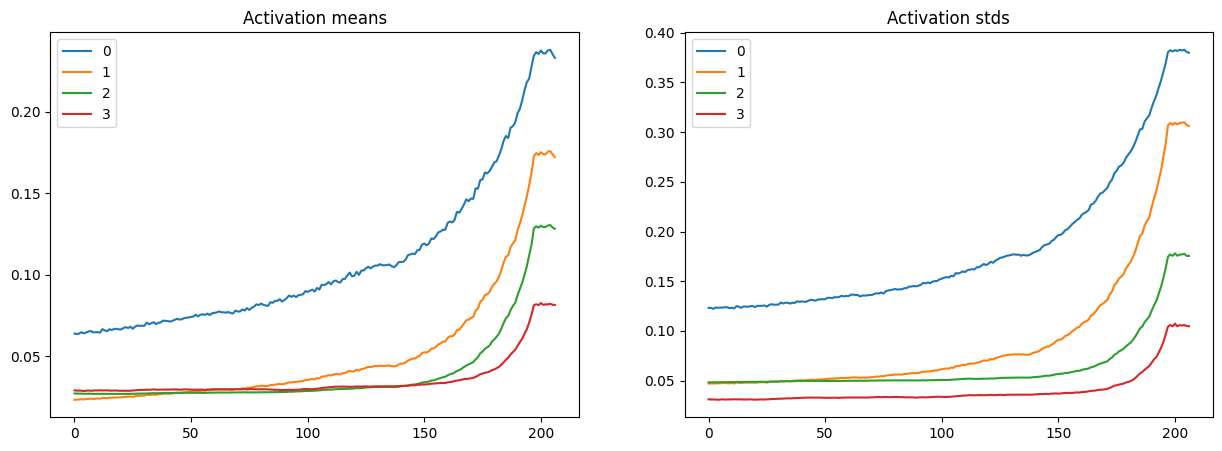

In [23]:
act_stats.plot_statistics()

#### Batch Normalization scratch development

In [24]:
X = torch.randn(8,3,16,16)
X.shape

torch.Size([8, 3, 16, 16])

In [25]:
"""
    For FC layer X.shape = [b, out_features]
    dim=(0)
    For conv. layer X.shape = [b, c, w, h]
    dim=(0,2,3)
"""
def batch_norm(X, gamma=1, beta=0, eps=1e-5):

    mean = X.mean(dim=(0,2,3), keepdim=True)
    var = X.var(dim=(0,2,3), keepdim=True)
    X_norm = (X - mean)/torch.sqrt(var + eps)
    return X_norm * gamma + beta

In [26]:
X, y = train_dataset[0]
X.shape

torch.Size([1, 28, 28])

In [27]:
import numpy as np

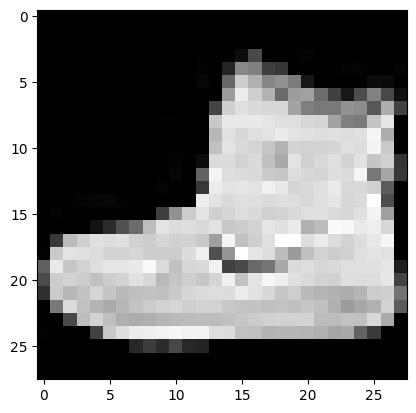

In [28]:
X = X/2 + 0.5
plt.imshow(np.transpose(X, (1,2,0)), cmap='gray')

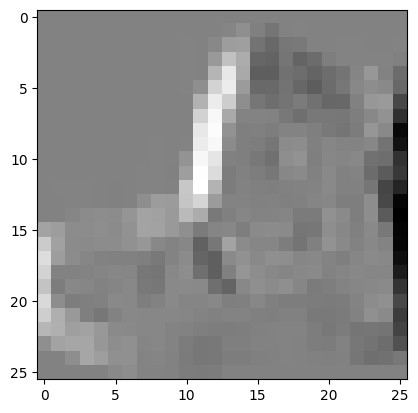

In [29]:
def apply_filter(im, filter):
    im_h, im_w = im.shape
    f_h, f_w = filter.shape
    output_data = []
    for i in range(im_h - f_h + 1):
        row = []
        for j in range(im_w - f_w + 1):
            row.append((im[i:i+f_h, j:j+f_w] * filter).sum().item())
        output_data.append(row)
    return torch.tensor(output_data)

left_edge_filter = torch.tensor([[-1, 0, 1],
                               [-1, 0, 1],
                               [-1, 0, 1]])
def relu(X):
    return torch.clamp(X, min=0)
X_ = X[0, :, :]
conv_out = apply_filter(X_, left_edge_filter)
plt.imshow(conv_out, cmap='gray')

In [30]:
print(conv_out.mean(), conv_out.std())

tensor(0.0442) tensor(0.6041)


In [31]:
conv_out = conv_out[None, None, :, :] # add two rank 
norm_out = batch_norm(conv_out, )

In [32]:
norm_out.shape

torch.Size([1, 1, 26, 26])

In [33]:
print(norm_out.mean(), norm_out.std())

tensor(-1.4108e-08) tensor(1.0000)


Normalized mean is close to 0 and std is close to 1

In [34]:
# plt.imshow(norm_out[0, 0, :, :], cmap='gray')

In [35]:
relu_out = relu(norm_out)

In [36]:
relu_out = relu_out[0,0,:,:]

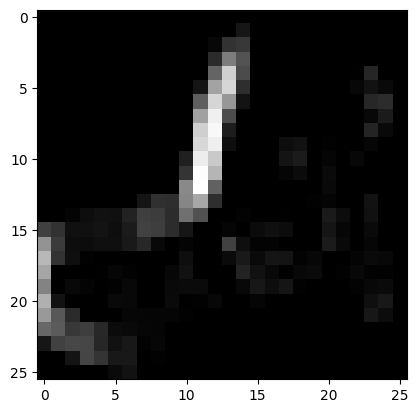

In [37]:
plt.imshow(relu_out, cmap='gray')

#### Batch normalization in PyTorch

##### Batch normalization

* For convolution layers, `nn.BatchNorm2d()`
* For FC layer, `nn.BatchNorm1d()`

**BatchNorm2D**:<br>
class `torch.nn.BatchNorm2d`(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)
  
**Parameters**:
* **num_features** (*int*) – $C$ from an expected input of size $(N,C,H,W)$

* **eps** (*float*) – a value added to the denominator for numerical stability. Default: 1e-5

* **momentum** (*Optional*[*float*]) – the value used for the running_mean and running_var computation. Can be set to None for cumulative moving average (i.e. simple average). Default: 0.1

* **affine** (*bool*) – a boolean value that when set to True, this module has learnable affine parameters. Default: True

* **track_running_stats** (*bool*) – a boolean value that when set to True, this module tracks the running mean and variance, and when set to False, this module does not track such statistics, and initializes statistics buffers running_mean and running_var as None. When these buffers are None, this module always uses batch statistics. in both training and eval modes. Default: True

**BatchNrom1D**: <br>
class `torch.nn.BatchNorm1d`(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)

**Parameters**:
* **num_features** (*int*) – number of features or channels $C$ of the input

* **eps** (*float*) – a value added to the denominator for numerical stability. Default: 1e-5

* **momentum** (*Optional*[*float*]) – the value used for the running_mean and running_var computation. Can be set to None for cumulative moving average (i.e. simple average). Default: 0.1

* **affine** (*bool*) – a boolean value that when set to True, this module has learnable affine parameters. Default: True

* **track_running_stats** (*bool*) – a boolean value that when set to True, this module tracks the running mean and variance, and when set to False, this module does not track such statistics, and initializes statistics buffers running_mean and running_var as None. When these buffers are None, this module always uses batch statistics. in both training and eval modes. Default: True

In [38]:
X, y = next(iter(train_loader))
X.shape

torch.Size([1024, 1, 28, 28])

In [39]:
conv_out = nn.Conv2d(1,8, kernel_size=3, stride=3, padding=1)(X)
norm_out = nn.BatchNorm2d(8)(conv_out)

In [40]:
print(conv_out.mean(), conv_out.std())
print(norm_out.mean(dim=(0,2,3)), norm_out.std(dim=(0,2,3)))

tensor(0.0005, grad_fn=<MeanBackward0>) tensor(0.3983, grad_fn=<StdBackward0>)
tensor([-9.3132e-11, -4.3958e-09,  5.4147e-08,  3.3746e-08,  2.7791e-08,
         1.9204e-08,  1.5693e-08, -3.0315e-09], grad_fn=<MeanBackward1>) tensor([1.0000, 1.0000, 0.9999, 0.9999, 1.0000, 0.9999, 1.0000, 0.9999],
       grad_fn=<StdBackward0>)


In [41]:
# get scale and shift
list(nn.BatchNorm2d(8).parameters())

[Parameter containing:
 tensor([1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)]

#### Integrade Batch Normalization with a learn loop

In [42]:
def get_conv_model():
    return nn.Sequential(
        # 1x28x28
        nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(4),
        nn.ReLU(),
        # 4x14x14
        nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(8),            
        nn.ReLU(),
        # 8x7x7
        nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        # 16x4x4
        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(32, 10)

    )

In [43]:
conv_model_w_bn = get_conv_model()

In [44]:
act_stats = ActivationStatistics(conv_model_w_bn)

In [45]:
opt = optim.SGD(conv_model_w_bn.parameters(), lr=0.6)
train_losses, val_losses, val_accuracies = utils.learn(conv_model_w_bn,train_loader, val_loader, opt, F.cross_entropy, num_epoch=3)

epoch: 0: train error: 0.8756813078613604, validation error: 0.6775076508522033, validation accuracy: 0.7526885390281677


epoch: 1: train error: 0.4538007014888828, validation error: 0.4738933235406876, validation accuracy: 0.8197704076766967


epoch: 2: train error: 0.4041143312292584, validation error: 0.42619294822216036, validation accuracy: 0.8416932404041291


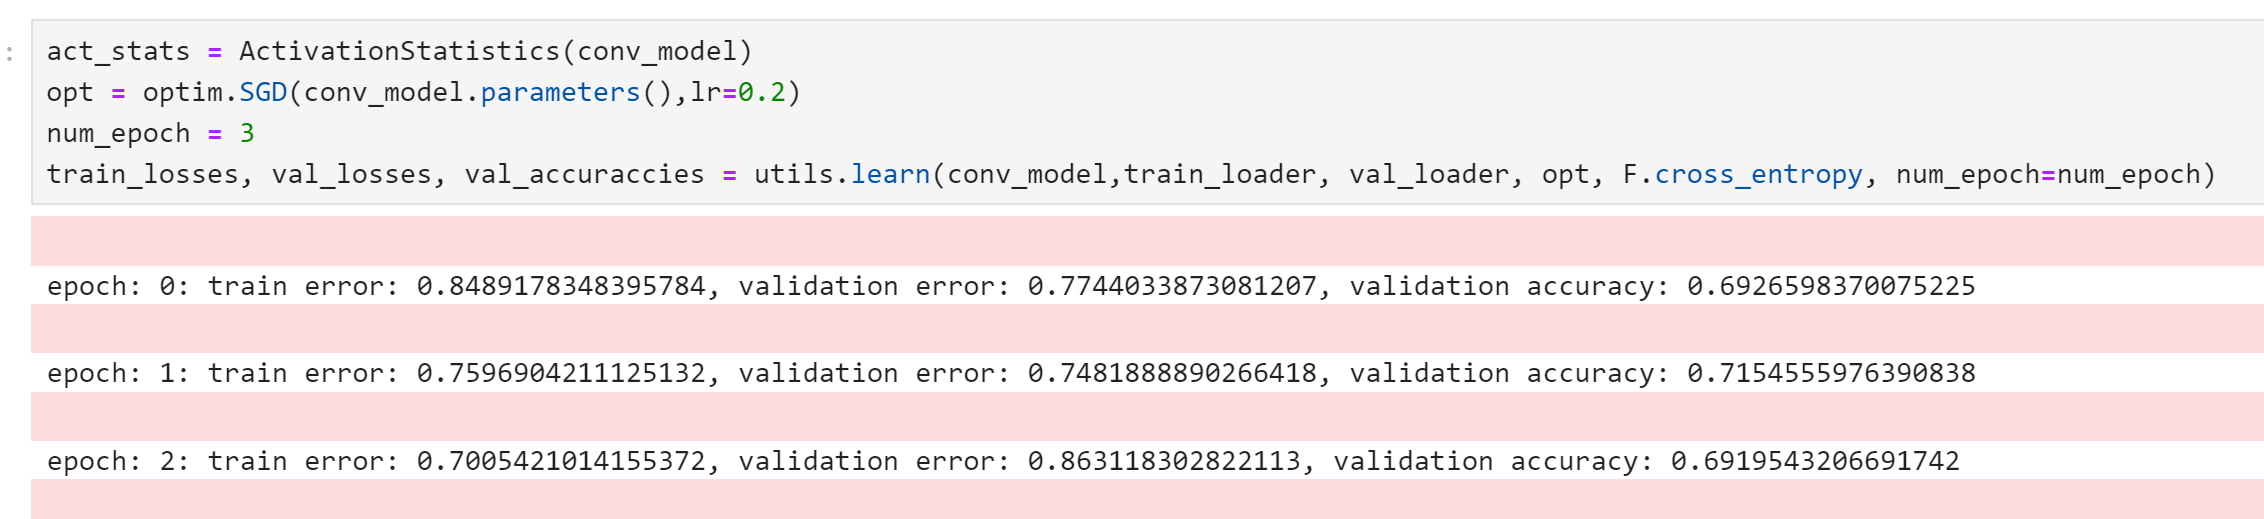

Compared with the previous model without batch normalization, validation accuray rapidly increases

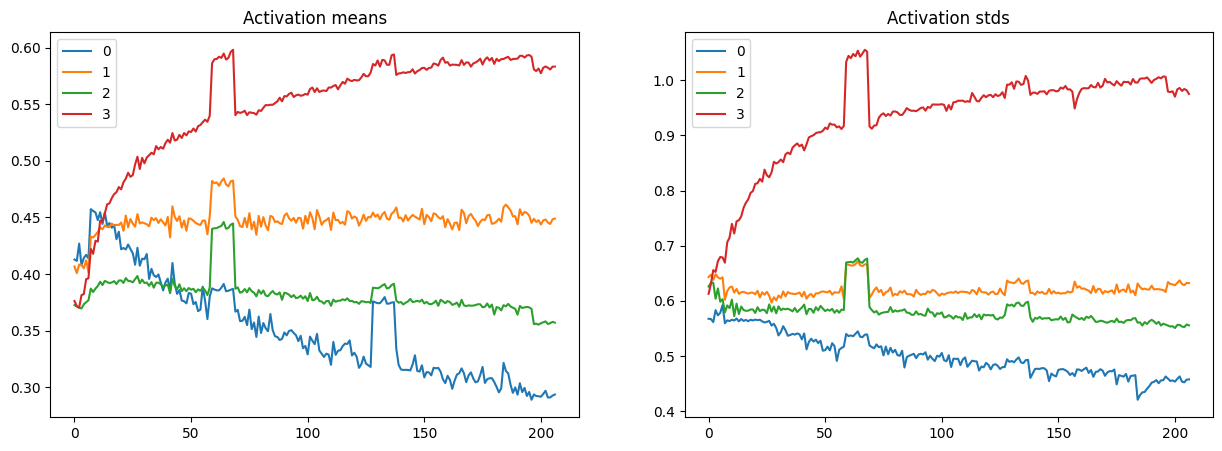

In [46]:
act_stats.plot_statistics()

Batch normalization effectively suppressed internal covariate shift. Large spikes observed in the previous model without batch normalization disappear.

### Layer Normalization

<img src="./rsc/batch_layer_normalization_2.png" width="600" height="800">
<img src="./rsc/batch_layer_normalization.png" width="600" height="800">

source: adapted from [Group Normalization](https://arxiv.org/abs/1803.08494)

In [47]:
def layer_norm(X, gamma=1, beta=0, eps=1e-5):

    mean = X.mean(dim=(1,2,3), keepdim=True)
    var = X.var(dim=(1,2,3), keepdim=True)
    X_norm = (X - mean)/torch.sqrt(var + eps)
    return X_norm * gamma + beta

In [48]:
def get_conv_model_ln():
    return nn.Sequential(
        # 1x28x28
        nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
        nn.LayerNorm(4,14,14),
        nn.ReLU(),
        # 4x14x14
        nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
        nn.LayerNorm(8,7,7),            
        nn.ReLU(),
        # 8x7x7
        nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
        nn.LayerNorm(16,4,4),
        nn.ReLU(),
        # 16x4x4
        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        nn.LayerNorm(32,2,2),
        nn.ReLU(),

        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(32, 10)

    )
    
conv_model_w_ln = get_conv_model_ln()
act_stats = ActivationStatistics(conv_model_w_bn)
opt = optim.SGD(conv_model_w_bn.parameters(), lr=0.6)
train_losses, val_losses, val_accuracies = utils.learn(conv_model_w_bn,train_loader, val_loader, opt, F.cross_entropy, num_epoch=3)


epoch: 0: train error: 0.36841097928709904, validation error: 0.45690985321998595, validation accuracy: 0.8230827510356903


epoch: 1: train error: 0.34841862472437196, validation error: 0.4076177328824997, validation accuracy: 0.8513014197349549


epoch: 2: train error: 0.3297034047417722, validation error: 0.4053559392690659, validation accuracy: 0.8505361139774322


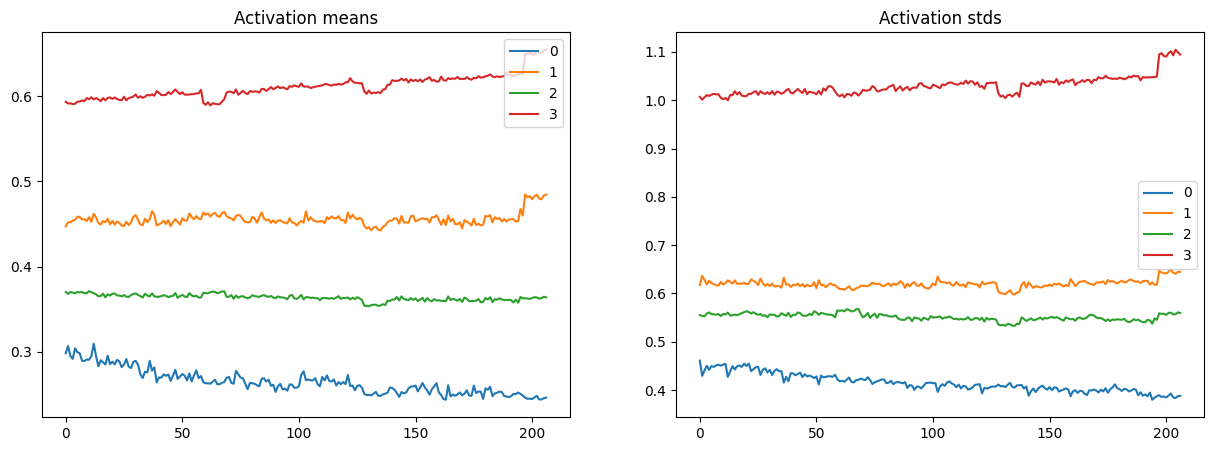

In [49]:
act_stats.plot_statistics()